# BARABÁSI-ALBERT MODEL

## Six Degrees of Kevin Bacon

![kevin](Kevin_Bacon.jpg)


1994.godine glumac Kevin Bacon je u intervjuu izjavio da je radio sa svakim glumcem u Hollywoodu ili s nekim tko je s njime radio.

Temeljem toga inspirirana je igra koja svakom glumcu pridružuje *Bacon*-ov broj koji govori koliko je osoba udaljena od Kevina Bacona s obzirom na osobe s kojima je surađivala na filmovima.
* Kevin Bacon ima Baconov broj 0
* Osoba koja je direktno surađivala s njime 1
* Ako je najmanji Baconov broj od svih osoba s kojima je neka osoba surađivala N onda je njen Baconov broj N+1

Npr. Ian McKellen je glumio u *X-Men:Days of Future Past(2014)* s Michaelom Fassbenderom i Jamesom McAvoyem, a McAvoy i Fassbender su glumili s Baconom u *X-Men: First Class (2011)*. Stoga McAvoy i Fassbender imaju Baconov broj 1 dok McKellen ima Baconov broj 2.

Pretpostavka je da ni za jednog glumca ovaj broj ne prelazi 6. Naziv je inspiriran s 6 stupnjeva separacije ili pravilom 6 rukovanja koje kaže da su bilo koja dva čovjeka udaljena poznanstvima u najviše šest koraka.

Kevin Bacon je 2007. godine pokrenuo dobrotvornu udrugu [Six Degrees](https://en.wikipedia.org/wiki/SixDegrees.org)

## Mali svijet

Ja se neću ovdje baviti koliki je Baconov broj svakog glumca već ću kroz jedan model pokušati objasniti zašto je svijet tako mali.

Prikažimo glumce kao vrhove u grafu gdje bridovi predstavljaju filmove u kojem su dva glumca glumila zajedno. Npr. 

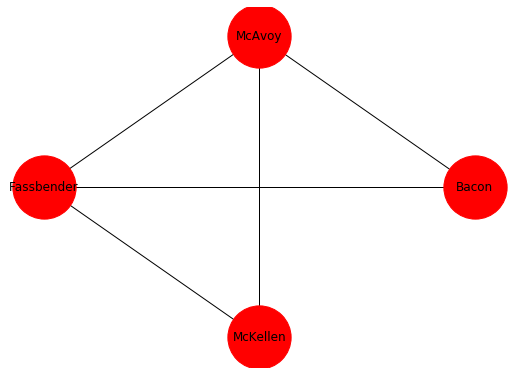

In [27]:
import networkx as nx
import matplotlib.pyplot as plt

g=nx.Graph()
g.add_edge('Bacon','McAvoy') 
g.add_edge('Bacon','Fassbender')
g.add_edge('Fassbender','McAvoy')
g.add_edge('Fassbender','McKellen')
g.add_edge('McAvoy','McKellen')

pos = nx.shell_layout(g)
plt.figure(figsize=(7,5))
nx.draw(g, pos, node_size=4000, with_labels=True, node_color='r')
plt.show()

In [10]:
g.edges()

EdgeView([('Bacon', 'McAvoy'), ('Bacon', 'Fassbender'), ('McAvoy', 'Fassbender'), ('McAvoy', 'McKellen'), ('Fassbender', 'McKellen')])

## Scale free network
Stupanj vrha je broj bridova koji iz njega izlazi.

Distribucija stupnjeva je vjerojatnosna distribucija stupnjeva u cijelom grafu. To jest distribucija stupnja $P(k)$ je udio vrhova u grafu koji imaju stupanj $k$. Odnosno ako u grafu s $n$ vrhova ima $n_{k}$ vrhova stupnja k tada je $P(k)=\frac{n_{k}}{n}$

Za graf kažemo da je *scale-free* ako distribucija stupnjeva zadovoljava *power law* odnosno oblika je $P(k)=\alpha x^{-k}$

Promotrimo model koji generira *scale-free* graf.

## Barabasi-Albert model

Krećemo s grafom od $m_{0}$ čvorova koji mogu biti proizvoljno povezani.
* **Rast**: u svakom koraku dodajemo novi vrh koji povežemo s $m$ vrhova koji su već u grafu
* **Preferential attachment**: vjerojatnost da se novi vrh poveže s vrhom $i$ je $\pi(k_{i})=\frac{k_{i}}{\sum k_{i}}$ gdje je $k_{i}$ stupanj vrha i.

Pratimo promjenu stupnja vrha $i$ kroz vrijeme.

$\frac{\partial k_{i}}{\partial t}\propto m \frac{k_{i}}{\sum_{i=1}^{N-1} k_{i}}$

gdje je $t$ vremenski korak a N ukupan broj čvorova u grafu. Naime u svakom koraku dodajemo $m$ novih bridova a svaki ima vjerojatnost $\frac{k_{i}}{\sum_{i=1}^{N-1} k_{i}}$ da se poveže s $i$. ...



In [91]:
import random

def add_and_draw(G,i,m):
    degrees=nx.degree(G)
    node_prob={}
    for each in G.nodes():
        node_prob[each]=(float)(degrees[each])/(2*len(G.edges()))
    cumulative_node_prob=[]
    it=0
    for n,p in node_prob.items():
        temp=[n,it+p]
        cumulative_node_prob.append(temp)
        it=it+p

    G.add_node(i)
    pos=nx.circular_layout(G)
    boje=['b' for k in range(i)]
    boje.append('r')
    nx.draw(G,pos,node_color=boje,edge_color='black',node_size=1000)
    
    labels={}
    for k in range(i):
        labels[k]=f'{node_prob[k]:.2f}'
    labels[i]='new'    
    nx.draw_networkx_labels(G,pos,labels)
    
    num_edges_added=0
    selected_nodes=[]
    new_edges=[]

    while(num_edges_added<m):
        node_it=0
        u=random.uniform(0,1)
        while(u>cumulative_node_prob[node_it][1]):
            node_it+=1

        selected_node=node_it
        
        if selected_node in selected_nodes:
            continue
        else:
            selected_nodes.append(selected_node)

        G.add_edge(i,selected_node)
        num_edges_added+=1
        new_edges.append((i,selected_node))
        
    nx.draw_networkx_edges(G,pos,edgelist=new_edges,edge_color='r')
    plt.axis('off')
    plt.show()
    
    return 

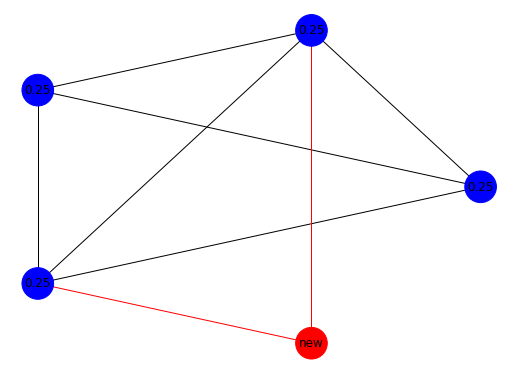

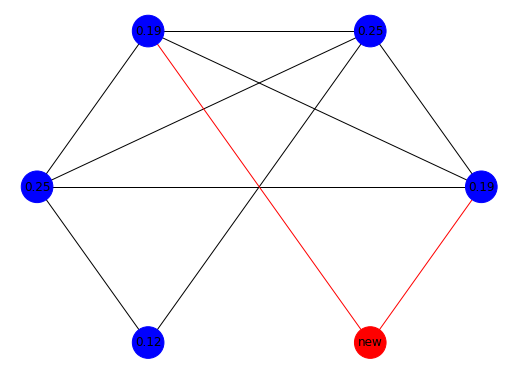

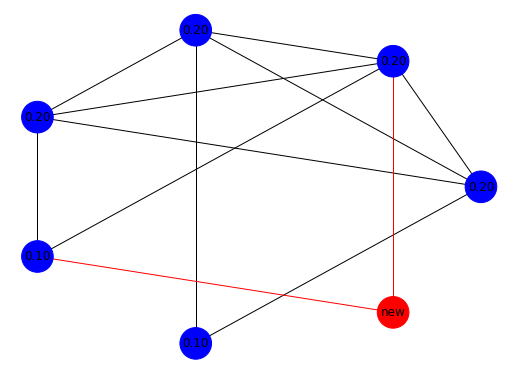

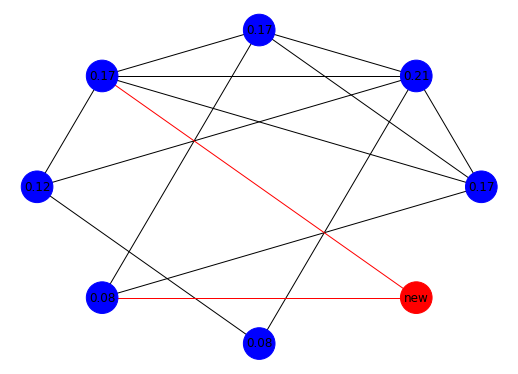

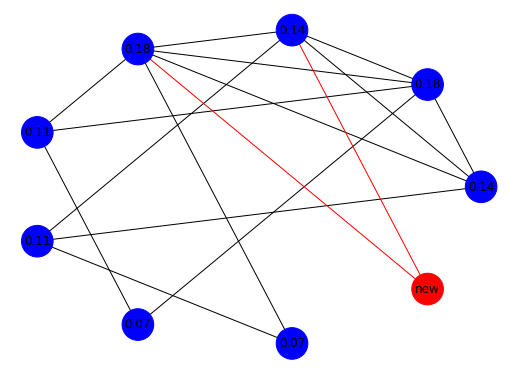

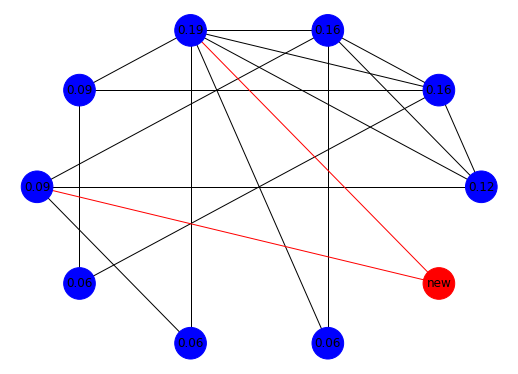

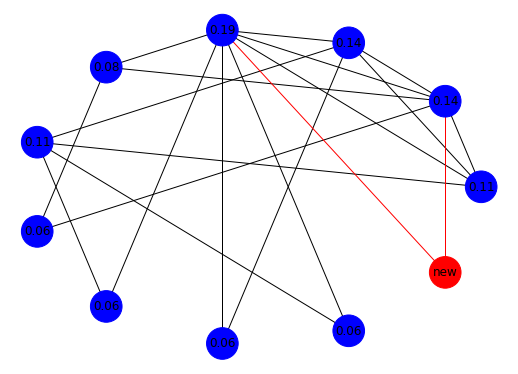

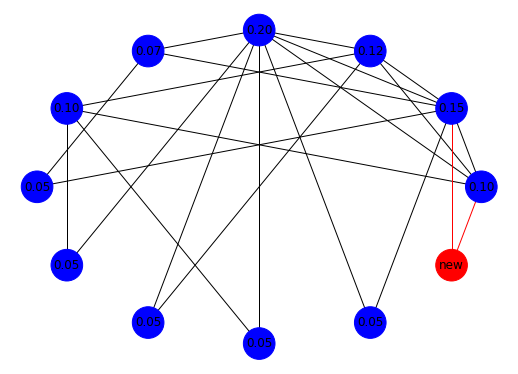

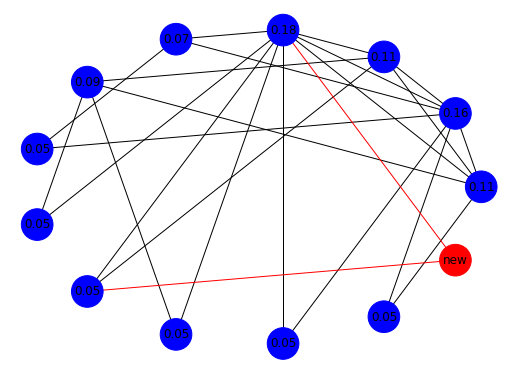

In [99]:
#plt.rcParams['figure.figsize'] = [7, 5]
m0=4
m=2
n=13

G=nx.complete_graph(m0)
for i in range(m0,n):
    add_and_draw(G,i,m)